In [7]:
from knn_chain import knn_chain

from scipy.cluster.hierarchy import ward
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.io import mmread, loadmat

# Time complexity analysis packages
import pstats, cProfile
import pyximport
pyximport.install()

# Memory complexity analysis packages
import tracemalloc

# Datasets
import tensorflow as tf

2024-09-26 15:17:41.753419: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 15:17:42.061613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 15:17:42.072797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 15:17:42.076245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 15:17:42.135194: I tensorflow/core/platform/cpu_feature_guar

# FUNCTIONS

In [2]:
def record_runtimes(X, ks, n = 10):
    
    avgs = []
    for k in ks:
        avg = 0.0
        for i in range(n):
            cProfile.runctx("knn_chain(X, k)", globals(), locals(), "Profile.prof")
            k1 = pstats.Stats("Profile.prof")
            avg += k1.strip_dirs().sort_stats("time").total_tt

        avg = avg/n
        avgs.append(avg)
        print(f"avg, k = {k} = {avg}")

    return avgs

In [70]:
def plot_runtimes(ks, avgs):
    str_ks = list(map(str, ks))
    
    plt.figure(figsize=(8, 6))
    plt.plot(str_ks, avgs, marker='o', c = '#D81B60', alpha=0.7)

    for i, avg in enumerate(avgs):
        plt.text(str_ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000',rotation=40, fontweight='bold')

    plt.title("Execution time comparison")
    plt.xlabel("Value of k")
    plt.xticks(ticks=str_ks, labels=str_ks) 
    plt.ylabel("Execution time in seconds")
    plt.grid(c = "#d3d3d3")
    plt.ylim(0, max(avgs) * 1.3)

    plt.show()

In [11]:
def plot_all_runtimes(times, ks, titles, label_indices):
    n = len(titles)  
    colours = ['#FFB000', '#FE6100', '#DC267F', '#785EF0', '#648FFF']
    
    cols = 3
    rows = (n + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(45, 15), sharex=False, sharey=False)

    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        indices = list(range(len(ks))) 
        axes[i].plot(indices, times[i], marker='o', color=colours[i % len(colours)])

        for j, avg in enumerate(times[i]):
            if j == label_indices[i]:
                axes[i].text(indices[j], avg, f'{avg:.4f}', ha='center', va='top', fontsize=25, color='#000000', rotation = 40, fontweight='bold')
            else:
                axes[i].text(indices[j], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=25, color='#000000', rotation = 40, fontweight='bold')

        axes[i].set_title(titles[i], fontsize=40)
        axes[i].set_xlabel('k', fontsize=30)
        axes[i].set_ylabel('Average Runtime (s)', fontsize=30)
        axes[i].grid(c="#d3d3d3")
        axes[i].set_ylim(bottom=0)
        axes[i].tick_params(axis='y', labelsize=20)
        axes[i].set_xticks(indices)
        axes[i].set_xticklabels([str(k) for k in ks], fontsize=20)

    for i in range(n, rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [5]:
def aux_set_axis_limits(ax, y):
    ax.set_ylim([min(y) - 100, max(y) + 100])
    ax.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) 

def plot_mem(mems, ks, titles):
    str_ks = list(map(str, ks))
    n = len(titles)
    colours = ['#FFB000', '#FE6100', '#DC267F', '#785EF0', '#648FFF']

    fig, axes = plt.subplots(1, n, figsize=(25, 5), sharex=False, sharey=False)
    bar_width = 0.7

    for i in range(n):
        axes[i].bar(str_ks, mems[i], color=colours[i], width=bar_width)
        axes[i].set_title(titles[i], fontsize=23)
        axes[i].set_xlabel('k', fontsize=19)
        axes[i].set_ylabel('Average Memory Consumption', fontsize=19)
        axes[i].grid(c="#d3d3d3")
        aux_set_axis_limits(axes[i], mems[i])
    
    plt.tight_layout()
    plt.show()

# VARIABLES

In [6]:
n = 20
ks = [1, 3, 6, 10, 15, 25, 35]

# Dataset Visualisation

## 1. Synthetic Dataset

In [160]:
s_X = np.loadtxt("datasets/generated_smallX")
med_X = np.loadtxt("datasets/generated_mediumX")
large_X = np.loadtxt("datasets/generated_largeX")
xl_X = np.loadtxt("datasets/generated_xlargeX")
xxl_X = np.loadtxt("datasets/generated_xxlargeX")

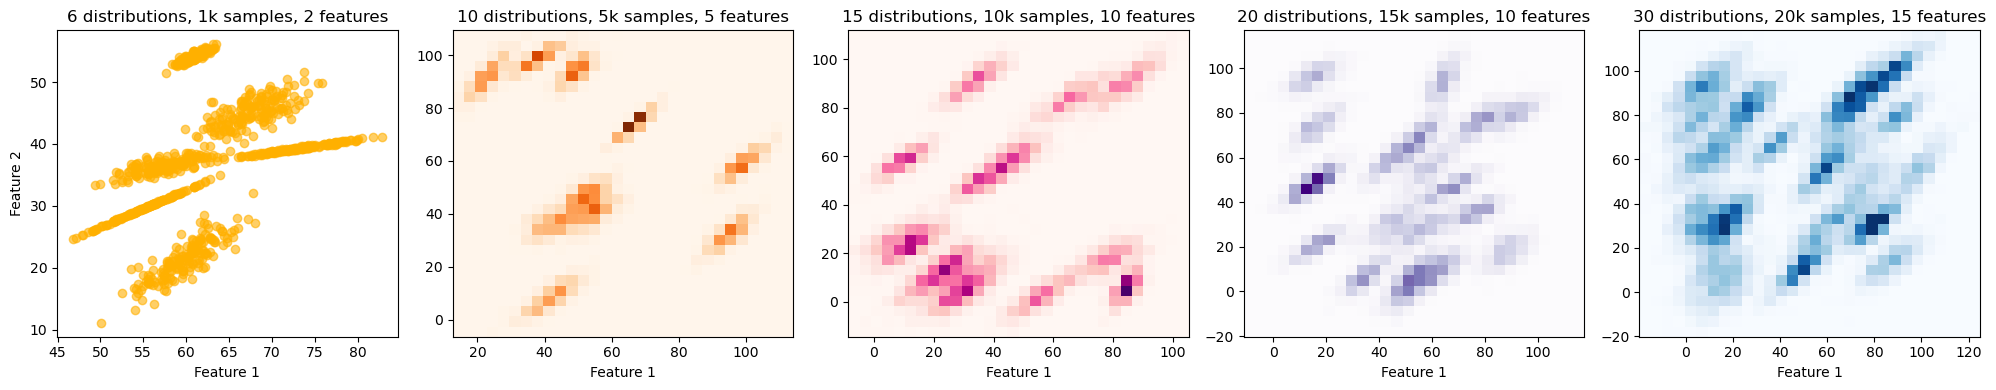

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)

# Plot for small_X
axes[0].scatter(s_X[:, 0], s_X[:, 1], alpha=0.6, c='#FFB000')
axes[0].set_title('6 distributions, 1k samples, 2 features')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot for med_X
axes[1].hist2d(med_X[:, 0], med_X[:, 1], bins=30, cmap='Oranges')
axes[1].set_title('10 distributions, 5k samples, 5 features')
axes[1].set_xlabel('Feature 1')

# Plot for large_X
axes[2].hist2d(large_X[:, 0], large_X[:, 1], bins=30, cmap='RdPu')
axes[2].set_title('15 distributions, 10k samples, 10 features')
axes[2].set_xlabel('Feature 1')

# Plot for xlarge_X
axes[3].hist2d(xl_X[:, 0], xl_X[:, 1], bins=30, cmap='Purples')
axes[3].set_title('20 distributions, 15k samples, 10 features')
axes[3].set_xlabel('Feature 1')

# Plot for xxlarge_X
axes[4].hist2d(xxl_X[:, 0], xxl_X[:, 1], bins=30, cmap='Blues')
axes[4].set_title('30 distributions, 20k samples, 15 features')
axes[4].set_xlabel('Feature 1')

# Adjust layout
plt.tight_layout()
plt.show()

## 2. MNIST

In [7]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
n_images = x_train.shape[0]
X_images = x_train.reshape(n_images, 28, 28)
mnist_data = X_images.reshape(n_images, 28 * 28)

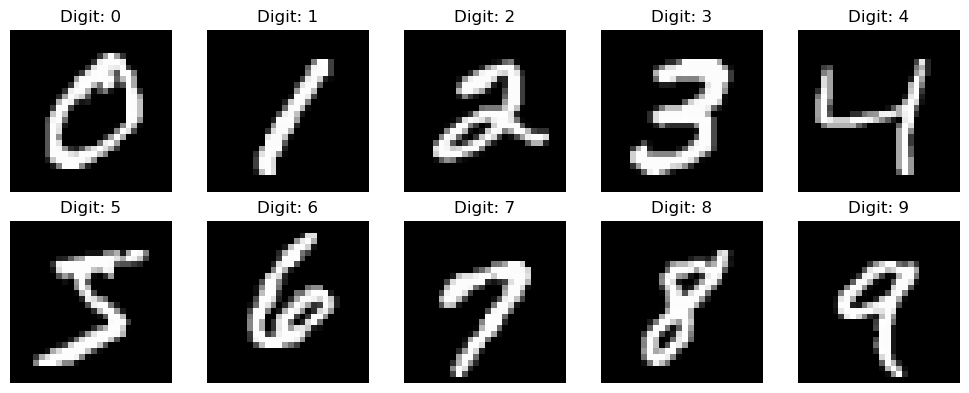

In [9]:
plt.figure(figsize=(10, 4))

for digit in range(10):
    index = (y_train == digit).nonzero()[0][0]
    plt.subplot(2, 5, digit + 1)
    plt.imshow(x_train[index], cmap='gray')
    plt.title(f'Digit: {digit}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# EXPERIMENTS

## Time Complexity

## 1. small X

In [67]:
s_X = np.loadtxt("datasets/generated_smallX")
avgs_small_gen = record_runtimes(s_X, all_ks, n)

avg, k = 1 = 0.0092716228
avg, k = 3 = 0.00843858075
avg, k = 6 = 0.00877929185
avg, k = 10 = 0.009109469799999999
avg, k = 15 = 0.010119290450000002
avg, k = 20 = 0.010690832550000001
avg, k = 25 = 0.014182899999999998
avg, k = 30 = 0.013909265700000003
avg, k = 35 = 0.0161262597
avg, k = 40 = 0.020495013700000002
avg, k = 45 = 0.04147509775000001
avg, k = 50 = 0.05722393669999999
avg, k = 90 = 0.0545644987


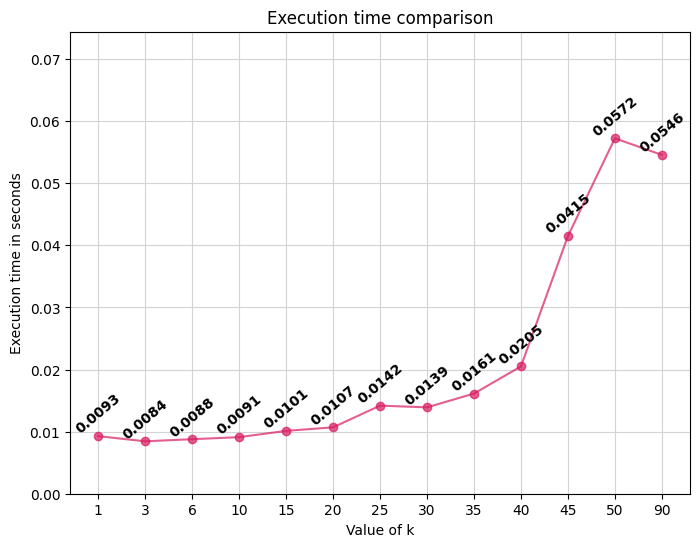

In [71]:
plot_runtimes(all_ks, avgs_small_gen)

## 2. medium X

avg, k = 1 = 0.27382107140000006
avg, k = 3 = 0.23497123074999998
avg, k = 6 = 0.22164272330000007
avg, k = 10 = 0.23500163464999999
avg, k = 15 = 0.23750694179999998
avg, k = 20 = 0.26802740645000006
avg, k = 25 = 0.2693213924000001
avg, k = 30 = 0.27906589005000015
avg, k = 35 = 0.2585657894000001
avg, k = 40 = 0.29356364665
avg, k = 45 = 0.29062166145000007
avg, k = 50 = 0.34393895250000006
avg, k = 90 = 0.44898453499999996


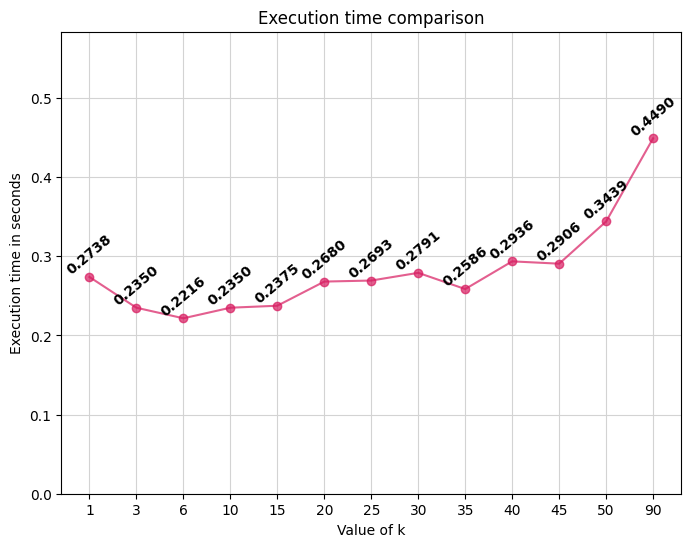

In [76]:
med_X = np.loadtxt("datasets/generated_mediumX")
avgs_med_gen = record_runtimes(med_X, all_ks, n)
plot_runtimes(all_ks, avgs_med_gen)

## 3. large X

avg, k = 1 = 1.6436269817000002
avg, k = 3 = 1.1786647491500004
avg, k = 6 = 1.1060027557500003
avg, k = 10 = 1.1735612947
avg, k = 15 = 1.26563631115
avg, k = 20 = 1.12426179175
avg, k = 25 = 1.2978548202000002
avg, k = 30 = 1.4920913355
avg, k = 35 = 1.4483893
avg, k = 40 = 1.3165541040500002
avg, k = 45 = 1.8421669437500003
avg, k = 50 = 1.42323996285
avg, k = 90 = 1.7350999747


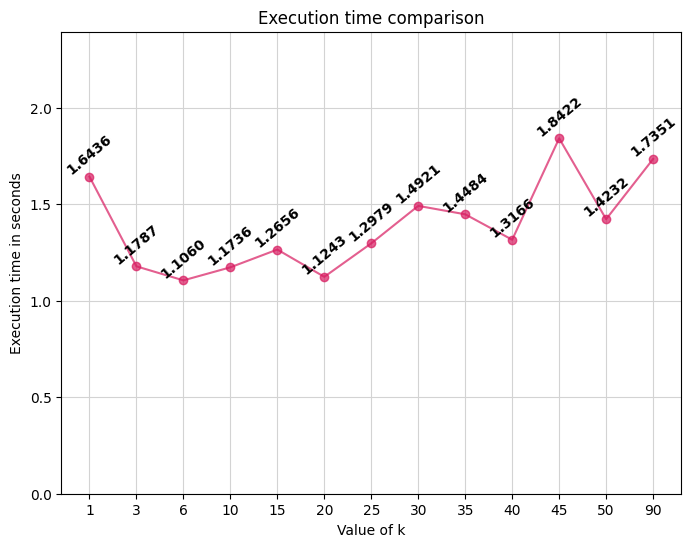

In [73]:
large_X = np.loadtxt("datasets/generated_largeX")
avgs_large_gen = record_runtimes(large_X, all_ks, n)
plot_runtimes(all_ks, avgs_large_gen)

## 4. extra large X

avg, k = 1 = 3.9912867418499998
avg, k = 3 = 3.0324749928
avg, k = 6 = 3.5122158897999993
avg, k = 10 = 3.190780004
avg, k = 15 = 3.00348316655
avg, k = 20 = 3.4699173129000003
avg, k = 25 = 3.2460742584999998
avg, k = 30 = 4.4616037447
avg, k = 35 = 4.9879111002
avg, k = 40 = 3.964028948850001
avg, k = 45 = 4.2485735070500015
avg, k = 50 = 3.8147063431000006
avg, k = 90 = 5.214770672600002


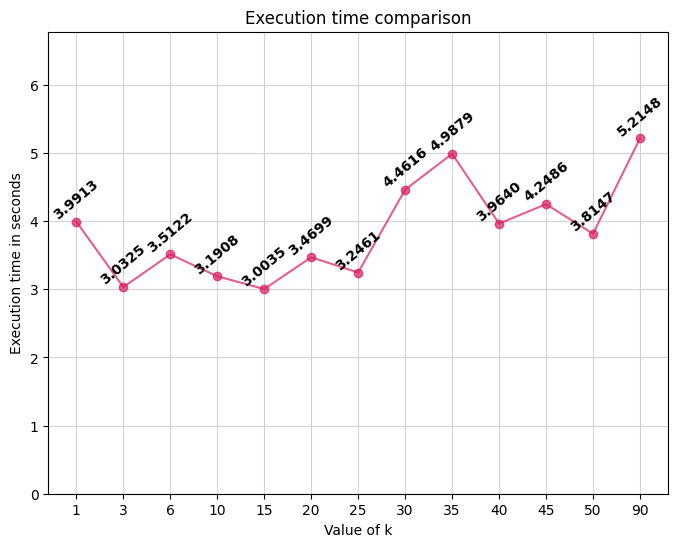

In [74]:
xl_X = np.loadtxt("datasets/generated_xlargeX")
avgs_xl_gen = record_runtimes(xl_X, all_ks, n)
plot_runtimes(all_ks, avgs_xl_gen)

## 5. extra extra large X

avg, k = 1 = 12.044756081600001
avg, k = 3 = 9.175321433400002
avg, k = 6 = 8.48931584075
avg, k = 10 = 11.257177029950004
avg, k = 15 = 7.334159685
avg, k = 20 = 9.032368960700001
avg, k = 25 = 8.9185879432
avg, k = 30 = 5.178173151949999
avg, k = 35 = 5.253498272500002
avg, k = 40 = 5.410990199550001
avg, k = 45 = 5.6889642967
avg, k = 50 = 5.7134715091
avg, k = 90 = 5.92760346575


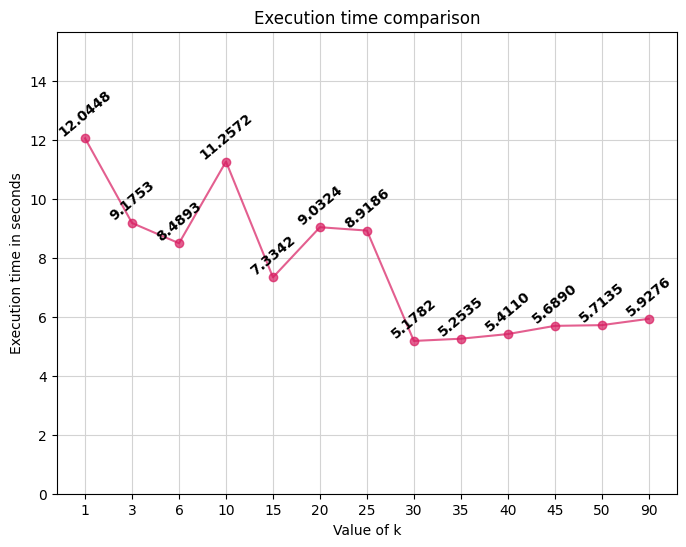

In [75]:
xxl_X = np.loadtxt("datasets/generated_xxlargeX")
avgs_xxl_gen = record_runtimes(xxl_X, all_ks, n)
plot_runtimes(all_ks, avgs_xxl_gen)

In [77]:
# !!!!!!!!
all_syn_avgs = [avgs_small_gen, avgs_med_gen , avgs_large_gen , avgs_xl_gen , avgs_xxl_gen]

In [143]:
all_syn_avgs =[[0.0092716228, 0.00843858075, 0.00877929185, 0.009109469799999999, 0.010119290450000002, 0.010690832550000001, 0.014182899999999998, 0.013909265700000003, 0.0161262597, 0.020495013700000002, 0.04147509775000001, 0.05722393669999999, 0.0545644987]
, [0.27382107140000006, 0.23497123074999998, 0.22164272330000007, 0.23500163464999999, 0.23750694179999998, 0.26802740645000006, 0.2693213924000001, 0.27906589005000015, 0.2585657894000001, 0.29356364665, 0.29062166145000007, 0.34393895250000006, 0.44898453499999996]
, [1.6436269817000002, 1.1786647491500004, 1.1060027557500003, 1.1735612947, 1.26563631115, 1.12426179175, 1.2978548202000002, 1.4920913355, 1.4483893, 1.3165541040500002, 1.8421669437500003, 1.42323996285, 1.7350999747]
, [3.9912867418499998, 3.0324749928, 3.5122158897999993, 3.190780004, 3.00348316655, 3.4699173129000003, 3.2460742584999998, 4.4616037447, 4.9879111002, 3.964028948850001, 4.2485735070500015, 3.8147063431000006, 5.214770672600002]
, [12.044756081600001, 9.175321433400002, 8.48931584075, 11.257177029950004, 7.334159685, 9.032368960700001, 8.9185879432, 5.178173151949999, 5.253498272500002, 5.410990199550001, 5.6889642967, 5.7134715091, 5.92760346575]]

## All of the values in one plot

In [23]:
titles = ['Synthetic Dataset 1','Synthetic Dataset 2','Synthetic Dataset 3','Synthetic Dataset 4','Synthetic Dataset 5']
label_indices = [len(all_syn_avgs[0])-2, len(all_syn_avgs[1])-1, len(all_syn_avgs[2])-3, len(all_syn_avgs[3])-1,0]

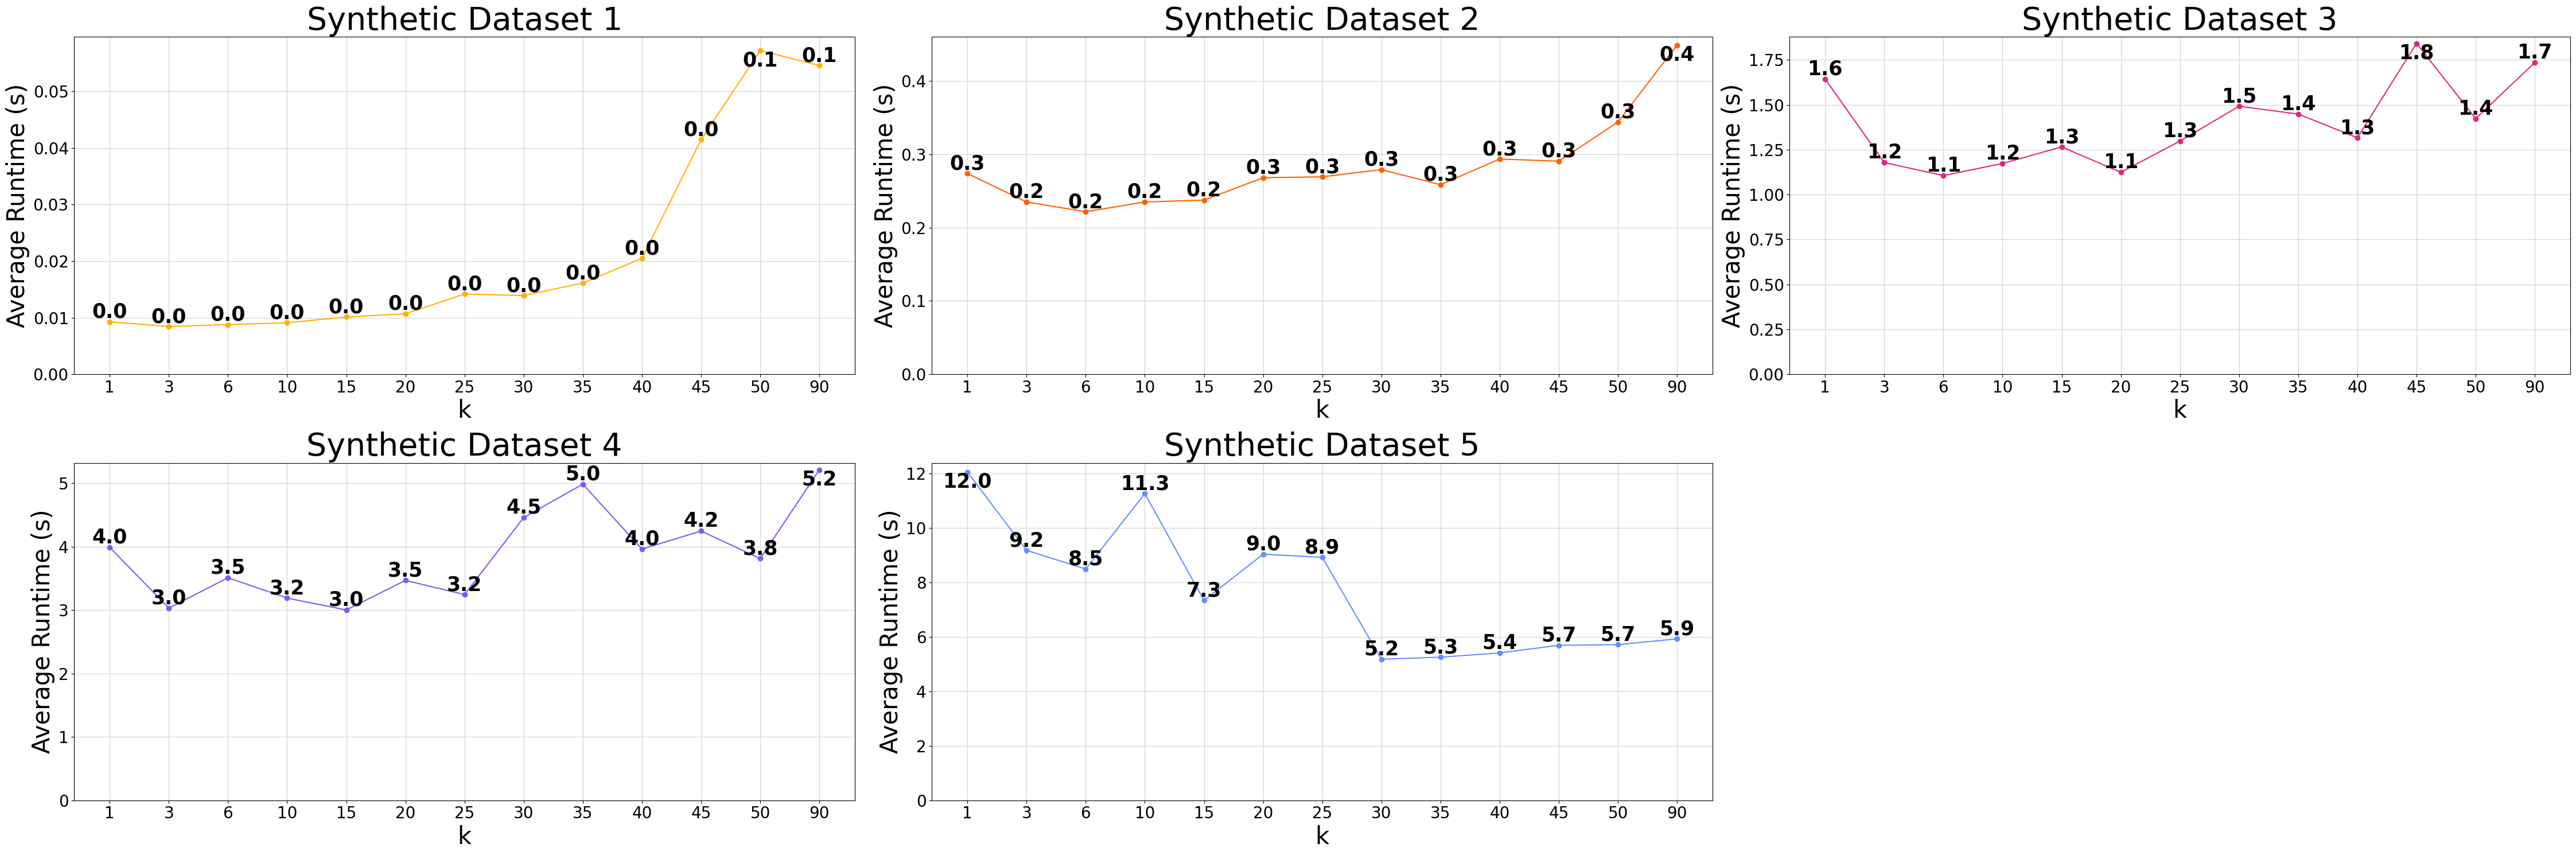

In [25]:
plot_all_runtimes(all_syn_avgs, all_ks, titles, label_indices)

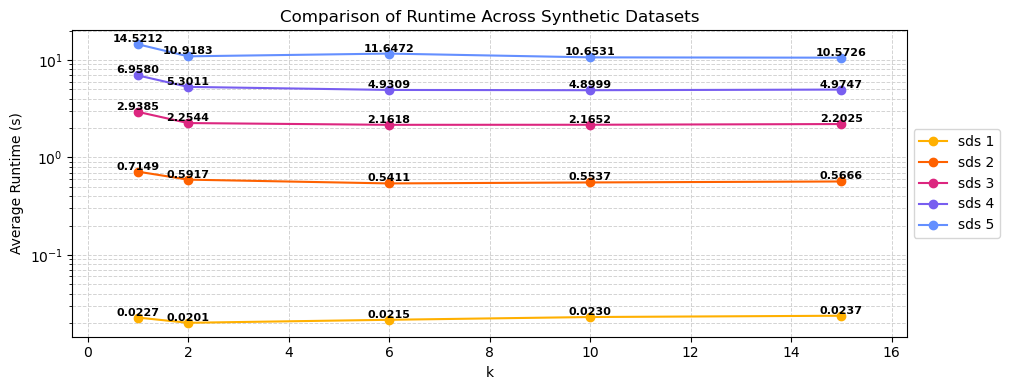

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
margin = 1.3

ax.plot(ks, avgs_small_gen, marker='o', color='#FFB000', label='sds 1')
for i, avg in enumerate(avgs_small_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_med_gen, marker='o', color='#FE6100', label='sds 2')
for i, avg in enumerate(avgs_med_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_large_gen, marker='o', color='#DC267F', label='sds 3')
for i, avg in enumerate(avgs_large_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_xl_gen, marker='o', color='#785EF0', label='sds 4')
for i, avg in enumerate(avgs_xl_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.plot(ks, avgs_xxl_gen, marker='o', color='#648FFF', label='sds 5')
for i, avg in enumerate(avgs_xxl_gen):
    ax.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=8, color='#000000', fontweight='bold')

ax.set_title('Comparison of Runtime Across Synthetic Datasets')
ax.set_xlabel('k')
ax.set_ylabel('Average Runtime (s)')

ax.set_yscale('log')
ax.set_xlim([min(ks) - margin, max(ks) + margin])
ax.grid(visible=True, which='both', color='#d3d3d3', linestyle='--', linewidth=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## 6. MNIST

In [27]:
big_ks = [20, 30, 40, 45, 50, 90]

In [23]:
ks = [1, 3, 10, 15, 25, 35]

In [5]:
all_ks = [1, 3, 6, 10, 15, 20, 25, 30, 35, 40, 45, 50, 90]

In [181]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
n_images = x_train.shape[0]
X_images = x_train.reshape(n_images, 28, 28)
mnist_data = X_images.reshape(n_images, 28 * 28)

In [36]:
avgs_mnist = [1213.5343788920004, 893.13191339, 823.909198216, 823.870315538, 819.8861402370001]

In [25]:
avgs_mnist = record_runtimes(mnist_data[:30000], ks, n=5)
# print("avg, k = 1 = 988.8486928634005")
# print("avg, k = 3 = 718.6719553010001")
# print("avg, k = 6 = 789.1722229159999")
# print("avg, k = 10 = 651.5456088142")
# print("avg, k = 15 = 773.8588412406")
# print("avg, k = 25 = 662.9650572072")
# print("avg, k = 35 = 657.3016670394001")

avg, k = 1 = 988.8486928634005
avg, k = 3 = 718.6719553010001
avg, k = 10 = 651.5456088142
avg, k = 15 = 773.8588412406
avg, k = 25 = 662.9650572072
avg, k = 35 = 657.3016670394001


In [26]:
avgs_mnist = record_runtimes(mnist_data[:30000], [6], n=5)

avg, k = 6 = 789.1722229159999


In [28]:
avgs_mnist2 = record_runtimes(mnist_data[:30000], big_ks, n=5)

avg, k = 20 = 700.8289792950002
avg, k = 30 = 744.5639847862003
avg, k = 40 = 805.7165362204001
avg, k = 45 = 705.1735037456001
avg, k = 50 = 807.5311081010001
avg, k = 90 = 704.7229769653999


In [15]:
mnist_avgs = [988.8486928634005, 718.6719553010001, 789.1722229159999,  651.5456088142,  773.8588412406,  700.8289792950002,  662.9650572072,  744.5639847862003,  657.3016670394001,  805.7165362204001,  705.1735037456001,  807.5311081010001,  704.7229769653999]

## 7. BBC News

In [182]:
matrix = mmread('datasets/bbc.mtx')
bbc_matrix = matrix.toarray().transpose()

In [127]:
# avgs_bbc = record_runtimes(bbc_matrix, ks, n=20)
print("avg, k = 1 = 57.03178337060001")
print("avg, k = 3 = 41.95408786329999")
print("avg, k = 6 = 37.74982151625")
print("avg, k = 10 = 48.06411870335001")
print("avg, k = 15 = 40.640545791300006")

avg, k = 1 = 57.03178337060001
avg, k = 3 = 41.95408786329999
avg, k = 6 = 37.74982151625
avg, k = 10 = 48.06411870335001
avg, k = 15 = 40.640545791300006


In [ ]:
avgs_bbc2 = record_runtimes(bbc_matrix, big_ks, n=20)
# avg, k = 20 = 40.99965332095
# avg, k = 25 = 40.86750714674999
# avg, k = 30 = 40.8883387581
# avg, k = 35 = 40.6200202031
# avg, k = 40 = 40.62088328045
# avg, k = 45 = 40.412292672250004
# avg, k = 50 = 40.4469395618
# avg, k = 90 = 40.2599467756

avg, k = 20 = 40.99965332095
avg, k = 25 = 40.86750714674999
avg, k = 30 = 40.8883387581
avg, k = 35 = 40.6200202031
avg, k = 40 = 40.62088328045
avg, k = 45 = 40.412292672250004
avg, k = 50 = 40.4469395618
avg, k = 90 = 40.2599467756


In [16]:
bbc_avgs = [57.03178337060001, 41.95408786329999, 37.74982151625, 48.06411870335001, 40.640545791300006, 40.99965332095, 40.86750714674999, 40.8883387581, 40.6200202031, 40.62088328045, 40.412292672250004, 40.4469395618, 40.2599467756]

## 3. Adult

In [183]:
adult = np.loadtxt("datasets/adult_train.data")
adult = np.nan_to_num(adult)

In [11]:
avgs_adult = record_runtimes(adult, [1, 3, 6, 10, 15, 25, 35], n=20)
# avg, k = 1 =  30.50481737015
# avg, k = 3 =  27.5109916694
# avg, k = 6 =  27.566467162149998
# avg, k = 10 = 14.9913871187
# avg, k = 15 = 23.82705790335
# avg, k = 25 = 19.352576617200004
# avg, k = 35 = 16.452511824450003

avg, k = 1 = 30.50481737015
avg, k = 3 = 27.5109916694
avg, k = 6 =  27.566467162149998
avg, k = 10 = 14.9913871187
avg, k = 15 = 23.82705790335
avg, k = 25 = 19.352576617200004
avg, k = 35 = 16.452511824450003


In [63]:
avgs_adult = record_runtimes(adult, [20, 30, 40, 45, 50, 90], n=20)
# avg, k = 20 = 18.077913790450005
# avg, k = 30 = 27.141350224400007
# avg, k = 40 = 18.134443920700004
# avg, k = 45 = 21.221163998100003
# avg, k = 50 = 20.6252676052
# avg, k = 90 = 24.171357628750005

avg, k = 20 = 18.077913790450005
avg, k = 30 = 27.141350224400007
avg, k = 40 = 18.134443920700004
avg, k = 45 = 21.221163998100003
avg, k = 50 = 20.6252676052
avg, k = 90 = 24.171357628750005


In [17]:
adult_avgs = [30.50481737015, 27.5109916694, 27.566467162149998, 14.9913871187, 23.82705790335, 18.077913790450005, 19.352576617200004, 27.141350224400007, 16.452511824450003, 18.134443920700004, 21.221163998100003, 20.6252676052, 24.171357628750005]

## Plotting all Real datasets

In [18]:
titles = ['MNIST','BBC News','Adult']
all_real_avgs = [mnist_avgs , bbc_avgs , adult_avgs]
label_indices = [0,0,0]

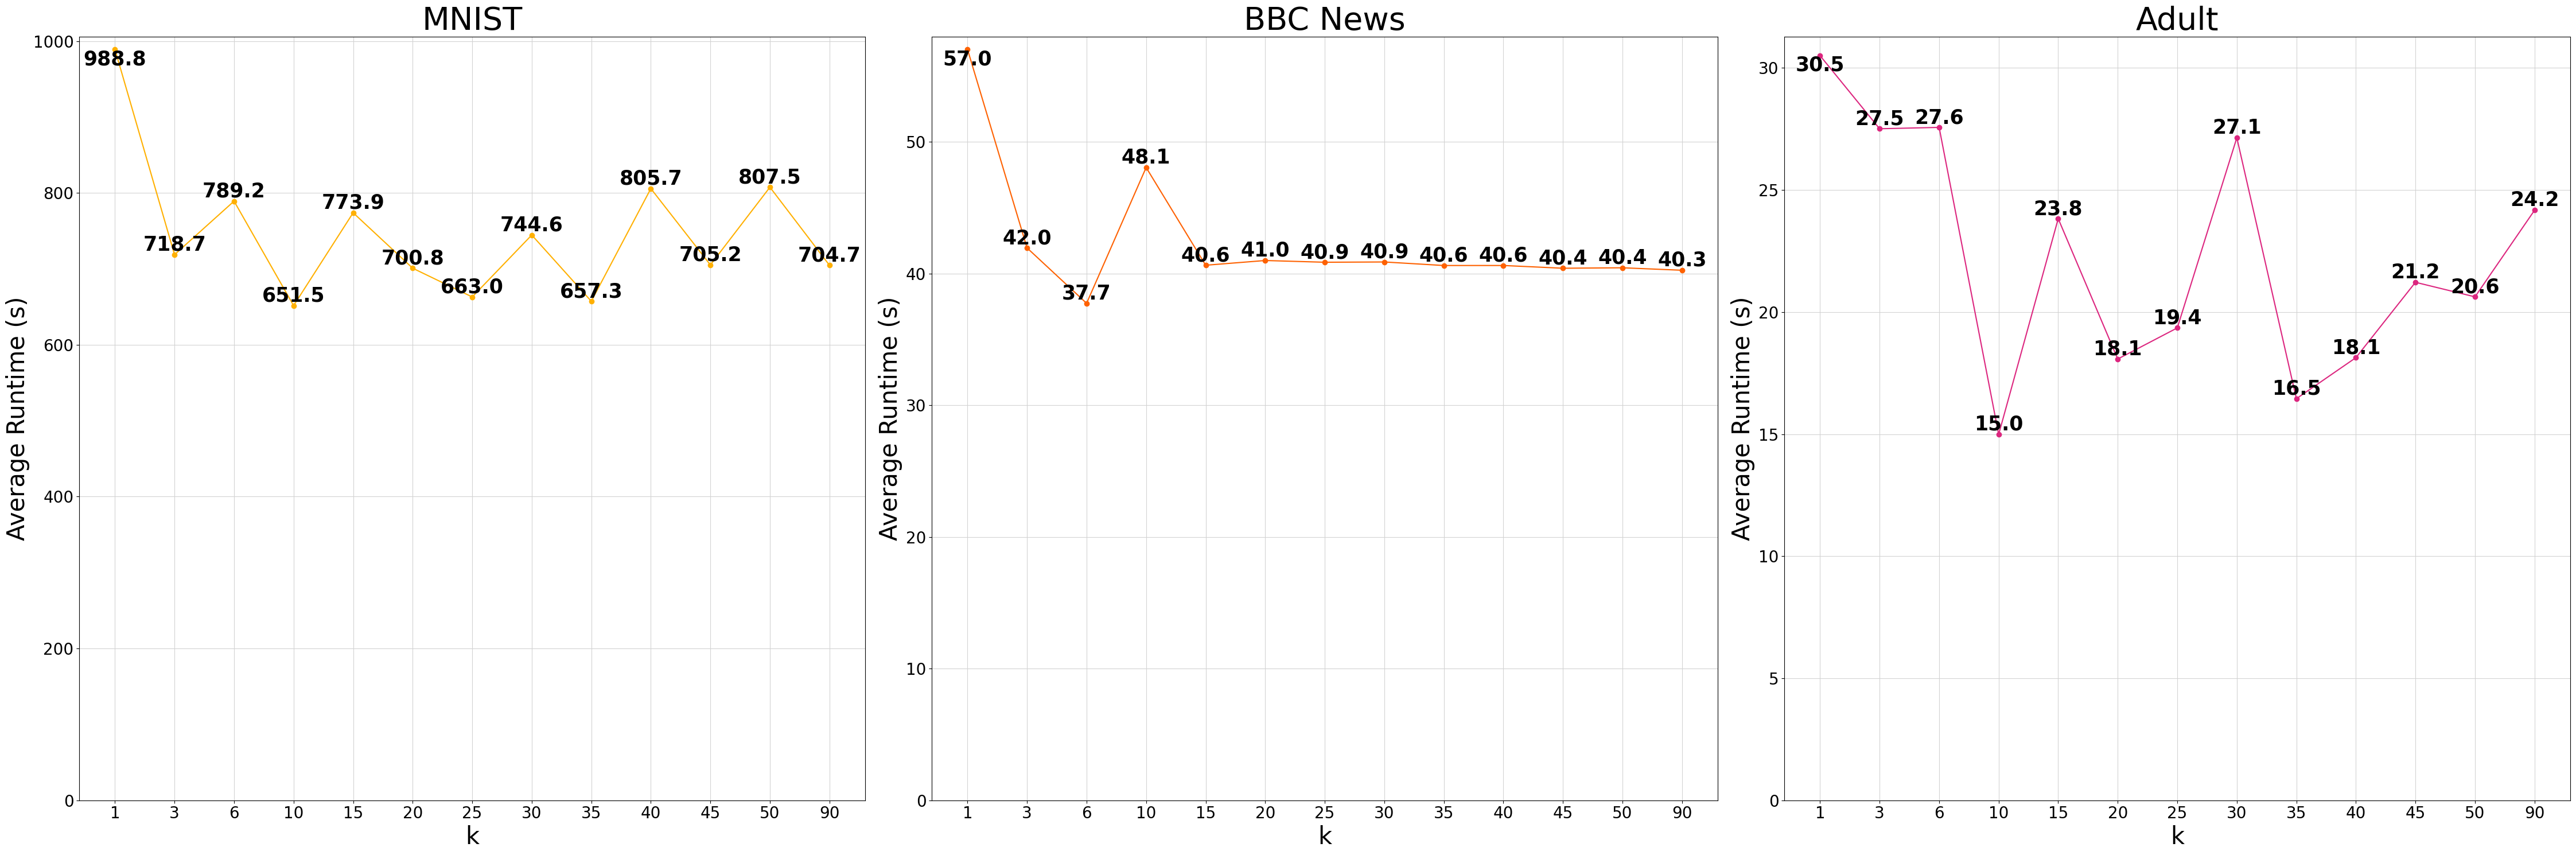

In [19]:
plot_all_runtimes(all_real_avgs, all_ks, titles, label_indices)

## Compare to SciPy

- Synthetic Dataset

In [164]:
n = 10
syn_nn_time = []
for ds in [s_X, med_X, large_X, xl_X, xxl_X]:
    avg = 0
    for _ in range(n):

        cProfile.runctx("pdist(ds)", globals(), locals(), "Profile.prof")
        k1 = pstats.Stats("Profile.prof")
        avg += k1.strip_dirs().sort_stats("time").total_tt

        y = pdist(ds)

        cProfile.runctx("ward(y)", globals(), locals(), "Profile.prof")
        k1 = pstats.Stats("Profile.prof")
        avg += k1.strip_dirs().sort_stats("time").total_tt
        
    avg = avg/n
    syn_nn_time.append(avg)
    print(f"avg = {avg}")

avg = 0.0069432072
avg = 0.31061797490000004
avg = 1.6004461912
avg = 3.8273605200000005
avg = 8.797727677500001


In [165]:
syn_nn_time

[0.0069432072,
 0.31061797490000004,
 1.6004461912,
 3.8273605200000005,
 8.797727677500001]

In [166]:
syn_nn_time = [0.0069432072, 0.31061797490000004, 1.6004461912, 3.8273605200000005, 8.797727677500001]

In [178]:
def plot_comparison(nn_chain_values, knn_chain_values, opt_values, x_labels, size=(12, 8)):
    # Create subplots in a single row
    n = len(nn_chain_values)
    fig, axes = plt.subplots(1, n, figsize=size, sharey=False)

    barWidth = 0.35  # Adjusted width for better spacing

    for i in range(n):
        br1 = np.arange(1)  # Position for NN Chain
        br2 = [x + barWidth for x in br1]  # Position for K-NN Chain
        br3 = [x + barWidth for x in br2]  # Position for opt

        # Create the bar plots for each dataset
        axes[i].bar(br1, nn_chain_values[i], color='#FFB000', width=.2, label='NN Chain', alpha=0.8)
        axes[i].bar(br2, knn_chain_values[i], color='#785EF0', width=.2, label='K-NN Chain', alpha=0.8)
        axes[i].bar(br3, opt_values[i], color='#DC267F', width=.2, label='Optimal-NN Chain', alpha=0.8) ##FFB000', '#FE6100', '#DC267F', '#785EF0', '#648FFF

        # Set titles and labels for each subplot
        axes[i].set_title(f'{x_labels[i]}', fontsize=20, pad=10)
        axes[i].set_ylabel('Execution Time', fontweight='bold', fontsize=12, labelpad=10)

        # Add value labels on top of the bars
        axes[i].text(br1[0], nn_chain_values[i], f'{nn_chain_values[i]:.4f}', ha='center', fontsize=11)
        axes[i].text(br2[0], knn_chain_values[i], f'{knn_chain_values[i]:.4f}', ha='center', fontsize=11)
        axes[i].text(br3[0], opt_values[i], f'{opt_values[i]:.4f}', ha='center', fontsize=11)

        # Set x-ticks and labels for both bars
        axes[i].set_xticks([br1[0] + barWidth / 40, br2[0] + barWidth / 40, br3[0] + barWidth / 40])  # Correctly set tick positions
        axes[i].set_xticklabels(['NN Chain', '1-NN Chain', 'Optimal-NN Chain'], fontsize=10)  # Set both labels
        axes[i].tick_params(axis='x', labelsize=10)

        # Grid for each subplot
        axes[i].grid(True, which='both', color="#d3d3d3", linewidth=0.5, alpha=0.7)

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    
    # Show plot
    plt.show()

In [179]:
best_knn = [min(x) for x in all_syn_avgs]

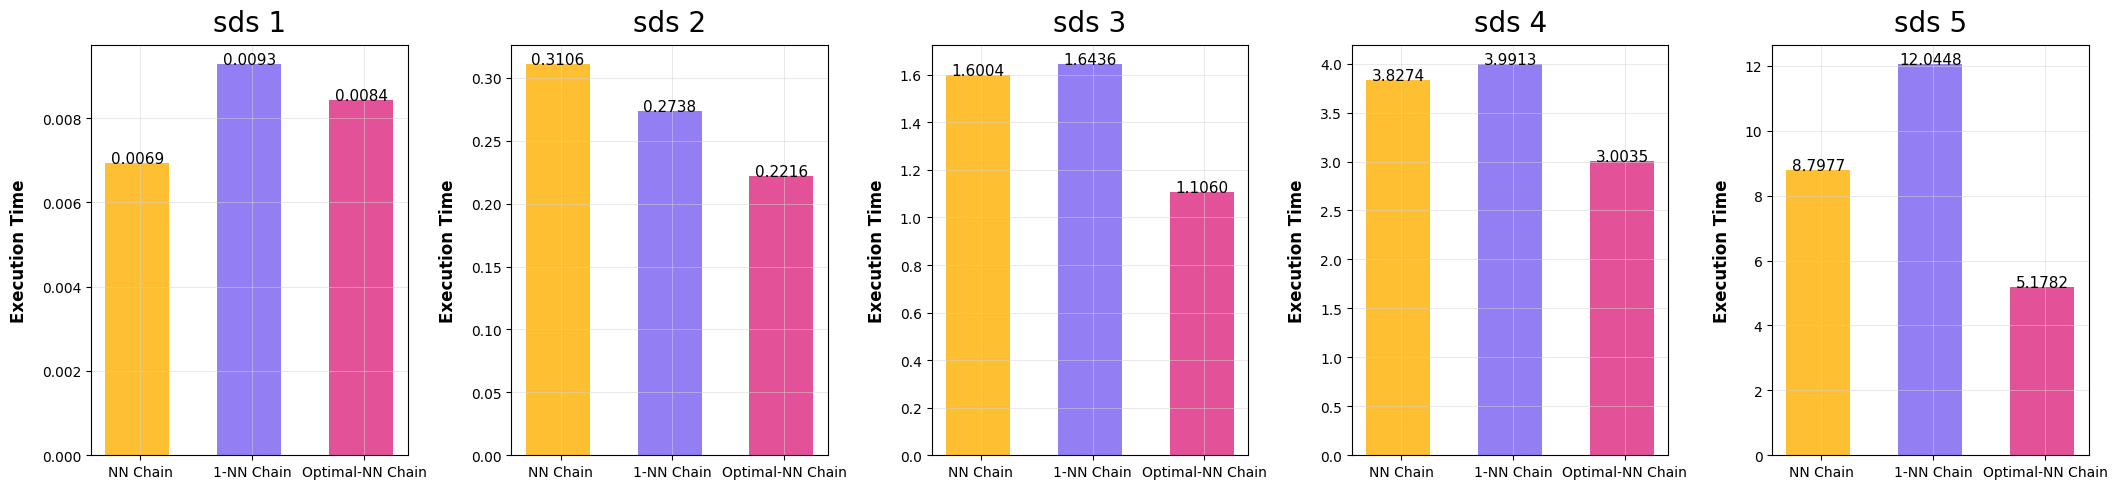

In [180]:
plot_comparison(syn_nn_time, np.array(all_syn_avgs)[:, 0], best_knn, ["sds 1", "sds 2", "sds 3", "sds 4", "sds 5"], size=(25, 5))

- Real Dataset

In [184]:
n = 10
real_nn_time = []
for ds in [mnist_data, bbc_matrix, adult]:
    avg = 0
    for _ in range(n):

        cProfile.runctx("pdist(ds)", globals(), locals(), "Profile.prof")
        k1 = pstats.Stats("Profile.prof")
        avg += k1.strip_dirs().sort_stats("time").total_tt

        y = pdist(ds)

        cProfile.runctx("ward(y)", globals(), locals(), "Profile.prof")
        k1 = pstats.Stats("Profile.prof")
        avg += k1.strip_dirs().sort_stats("time").total_tt
        
    avg = avg/n
    real_nn_time.append(avg)
    print(f"avg = {avg}")

In [ ]:
best_real_knn = [min(x) for x in all_real_avgs]

In [ ]:
plot_comparison(syn_nn_time, np.array(all_real_avgs)[:, 0], best_real_knn, ["MNIST", "BBC News", "Adult"], size=(25, 5))

## Memory Complexity

In [37]:
def record_memory(X, ks):
    mem = []
    for k in ks:
        tracemalloc.start()
        knn_chain(X, k)
        mem.append(tracemalloc.get_traced_memory()[1])
        tracemalloc.stop()
    return np.array(mem)

In [38]:
def wrapper_mem(X, ks, n):
    mem = np.zeros(len(ks))
    for _ in range(n):
        mem = mem + record_memory(X, ks)
    return mem/n

In [39]:
def human_format(x, pos):
        if x >= 1e9:
            return f'{x*1e-9:.1f}B'
        elif x >= 1e6:
            return f'{x*1e-6:.1f}M'
        elif x >= 1e3:
            return f'{x*1e-3:.1f}K'
        else:
            return f'{x:.0f}'

def plot_mem(nn_chain_results, knn_chain_results, dataset_sizes, x_title, x_labels, size = (12, 8)):
    barWidth = 0.25
    fig, ax = plt.subplots(figsize=(10, 7))

    br1 = np.arange(len(nn_chain_results))
    br2 = [x + barWidth for x in br1]

    ax.bar(br1, nn_chain_results, color='#FFB000', width=barWidth, label='NN Chain', alpha=0.8)
    ax.bar(br2, knn_chain_results, color='#FE6100', width=barWidth, label='KNN Chain', alpha=0.8)
    ax.scatter((br1+br2)/2, dataset_sizes, color='#DC267F', marker="^", s = 100, label='Dataset Size')

    ax.set_title('Memory usage of NN Chain vs KNN Chain', fontsize=18, pad=20)
    ax.set_xlabel(x_title, fontweight='bold', fontsize=15, labelpad=15)
    ax.set_ylabel('Memory Usage', fontweight='bold', fontsize=15, labelpad=15)
    ax.set_xticks([r + barWidth / 2 for r in range(len(nn_chain_results))])
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))

    # Add value labels on top of the bars (in human-readable format)
    for i in range(len(nn_chain_results)):
        ax.text(br1[i], nn_chain_results[i] * 1.1, human_format(nn_chain_results[i], None), ha='center', fontsize=10)
        ax.text(br2[i], knn_chain_results[i] * 1.1, human_format(knn_chain_results[i], None), ha='center', fontsize=10)
        ax.text((br1[i] + br2[i]) / 2, dataset_sizes[i] * 1.1, human_format(dataset_sizes[i], None), ha='center', fontsize=10, color='#DC267F')

    ax.grid(True, which='both', axis='y', c = "#d3d3d3", linewidth=0.5, alpha=0.7)
    ax.legend(loc='upper left', fontsize=10, frameon=False)
    fig.tight_layout()

    plt.show()

### Generated, synthetic data

In [50]:
s_X = np.loadtxt("datasets/generated_smallX")
med_X = np.loadtxt("datasets/generated_mediumX")
large_X = np.loadtxt("datasets/generated_largeX")
xl_X = np.loadtxt("datasets/generated_xlargeX")
xxl_X = np.loadtxt("datasets/generated_xxlargeX")

In [ ]:
s_mem = wrapper_mem(s_X, ks, n)
print(s_mem)

[184541.8  184213.2  184216.   184242.95 184216.  ]


In [ ]:
med_mem = wrapper_mem(med_X, ks, n)
print(med_mem)

[953196.7 953115.5 952987.2 953132.6 953072.4]


In [ ]:
large_mem = wrapper_mem(large_X, ks, n)
print(large_mem)

[1911940.35 1911668.1  1911647.4  1911589.3  1911665.4 ]


In [ ]:
xl_mem = wrapper_mem(xl_X, ks, n)
print(xl_mem)

[2873553.65 2873393.2  2873319.4  2873440.8  2873339.2 ]


In [ ]:
xxl_mem = wrapper_mem(xxl_X, ks, n)
print(xxl_mem)

[3830062.95 3829777.75 3829846.4  3829931.6  3829910.8 ]


In [7]:
s_mem = [184541.8,  184213.2,  184216.,   184242.95, 184216.]
med_mem = [953196.7, 953115.5, 952987.2, 953132.6, 953072.4]
large_mem = [1911940.35, 1911668.1, 1911647.4, 1911589.3, 1911665.4]
xl_mem = [2873553.65, 2873393.2, 2873319.4, 2873440.8, 2873339.2]
xxl_mem = [3830062.95, 3829777.75, 3829846.4, 3829931.6, 3829910.8]
syn_mems = [s_mem, med_mem, large_mem, xl_mem, xxl_mem]

In [25]:
titles = ['Synthetic Dataset 1','Synthetic Dataset 2','Synthetic Dataset 3','Synthetic Dataset 4','Synthetic Dataset 5']

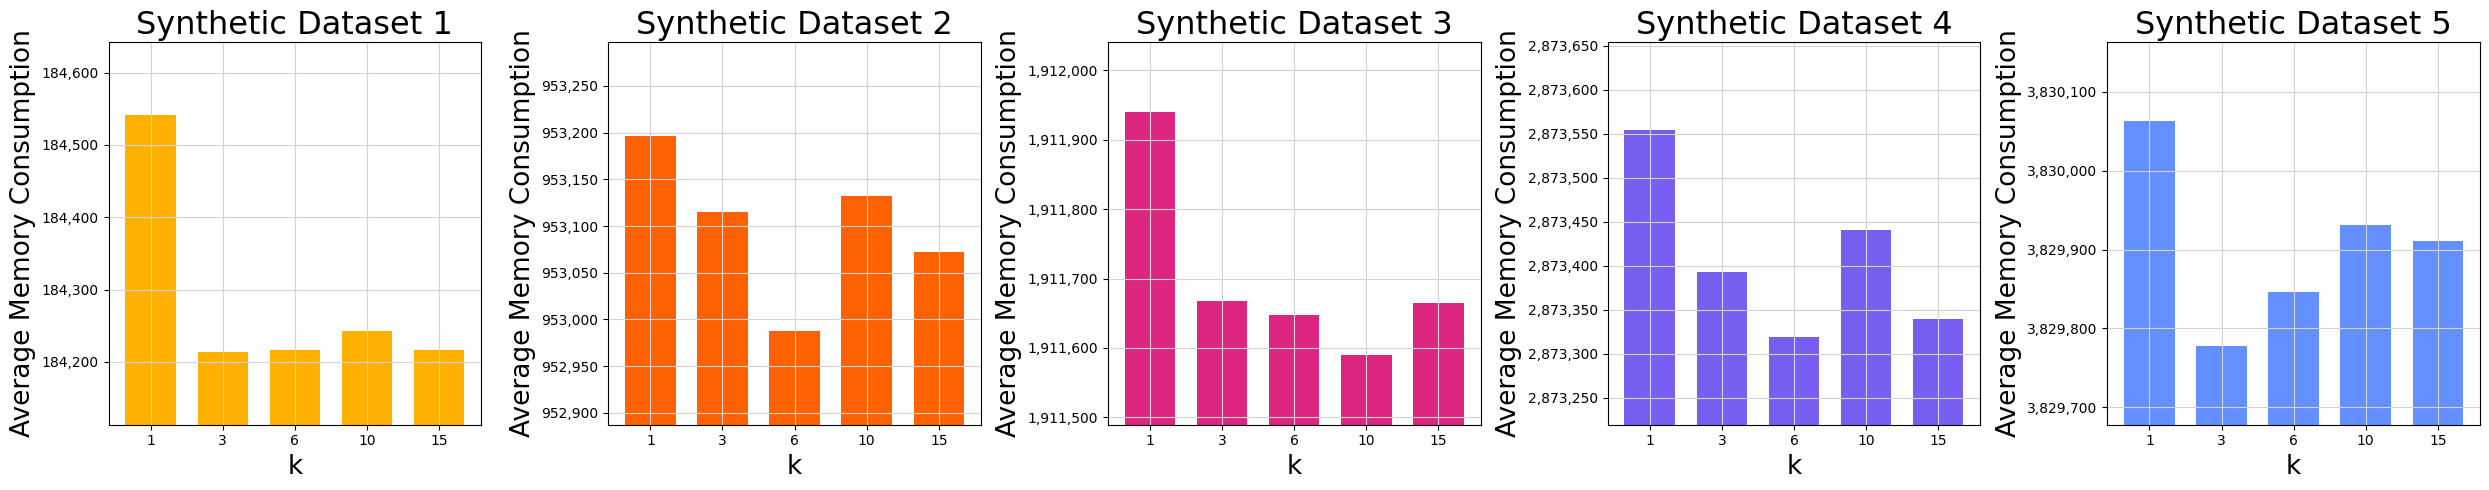

In [9]:
plot_mem(syn_mems, ks, titles)

In [97]:
def human_format(x, pos):
        if x >= 1e9:
            return f'{x*1e-9:.1f}B'
        elif x >= 1e6:
            return f'{x*1e-6:.1f}M'
        elif x >= 1e3:
            return f'{x*1e-3:.1f}K'
        else:
            return f'{x:.0f}'

def plot_mem(nn_chain_results, knn_chain_results, dataset_sizes, x_title, x_labels, size = (12, 8)):
    barWidth = 0.25
    fig, ax = plt.subplots(figsize=size)

    br1 = np.arange(len(nn_chain_results))
    br2 = [x + barWidth for x in br1]

    ax.bar(br1, nn_chain_results, color='#FFB000', width=barWidth, label='NN Chain', alpha=0.8)
    ax.bar(br2, knn_chain_results, color='#785EF0', width=barWidth, label='KNN Chain', alpha=0.8)
    ax.scatter((br1+br2)/2, dataset_sizes, color='#DC267F', marker="^", s = 100, label='Dataset Size')

    ax.set_title('Memory usage of NN Chain vs KNN Chain', fontsize=18, pad=20)
    ax.set_xlabel(x_title, fontweight='bold', fontsize=15, labelpad=15)
    ax.set_ylabel('Memory Usage', fontweight='bold', fontsize=15, labelpad=15)
    ax.set_xticks([r + barWidth / 2 for r in range(len(nn_chain_results))])
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))

    # Add value labels on top of the bars (in human-readable format)
    for i in range(len(nn_chain_results)):
        ax.text(br1[i], nn_chain_results[i] * 1.1, human_format(nn_chain_results[i], None), ha='center', fontsize=9)
        ax.text(br2[i], knn_chain_results[i] * 1.1, human_format(knn_chain_results[i], None), ha='center', fontsize=9)
        ax.text((br1[i] + br2[i]) / 2, dataset_sizes[i] * 1.1, human_format(dataset_sizes[i], None), ha='center', fontsize=9, color='#DC267F')#'#785EF0', '#648FFF'

    ax.grid(True, which='both', axis='y', c = "#d3d3d3", linewidth=0.5, alpha=0.7)
    ax.legend(loc='upper left', fontsize=10, frameon=False)
    fig.tight_layout()

    plt.show()

In [43]:
syn_knn_mems = [184541.8, 953196.7, 1911940.35, 2873553.65, 3830062.95]

In [64]:
dataset_sizes_syn = []
for s in [s_X.shape, med_X.shape, large_X.shape, xl_X.shape, xxl_X.shape]:
    x = 1
    for d in s:
        x*=d
    dataset_sizes_syn.append(x)

### SciPy nn chain algorithm

In [ ]:
syn_nn_mems = []
for ds in [s_X, med_X, large_X, xl_X, xxl_X]:
    mem = 0
    for _ in range(n):
        tracemalloc.start()
        y = pdist(ds) 
        ward(y)
        mem += tracemalloc.get_traced_memory()[1]
        tracemalloc.stop()
    mem = mem/n
    syn_nn_mems.append(mem)

In [ ]:
syn_nn_mems = [4460810.4, 112478619.0, 449056671.8, 1012433606.0, 1796312996.0]

In [121]:
print("sds 5 memory nn:knn = ", syn_nn_mems[-1]/syn_knn_mems[-1])

sds 5 memory nn:knn =  469.0035175531514


### Plotting Synthetic Dataset

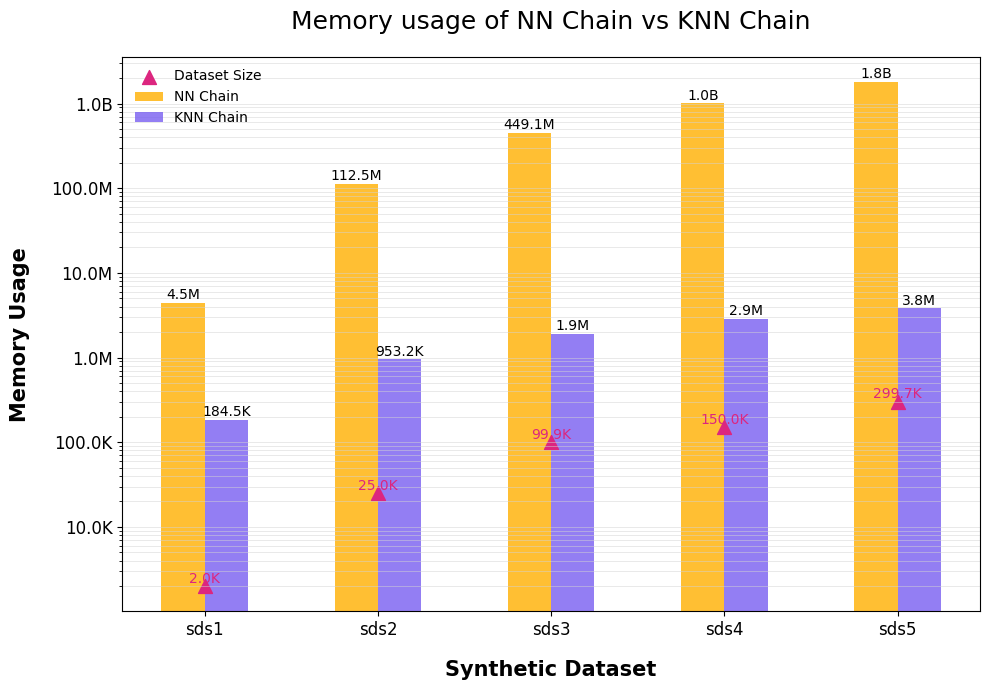

In [91]:
plot_mem(syn_nn_mems, syn_knn_mems, dataset_sizes_syn, 'Synthetic Dataset', ['sds1', 'sds2', 'sds3', 'sds4', 'sds5'], (10, 7))

## Real world datasets

In [29]:
# MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
n_images = x_train.shape[0]
X_images = x_train.reshape(n_images, 28, 28)
mnist_data = X_images.reshape(n_images, 28 * 28)
# BBC News
matrix = mmread('datasets/bbc.mtx')
bbc_matrix = matrix.toarray().transpose() # max = 81.0
# Adult Census
adult = np.loadtxt("datasets/adult_train.data")
adult = np.nan_to_num(adult)

In [30]:
dataset_sizes_real = []
for s in [mnist_data[:30000].shape, bbc_matrix.shape, adult.shape]:
    dataset_sizes_real.append(s[0])

### SciPy results

In [10]:
scipy_real_mems = []
for ds in [mnist_data[:30000], bbc_matrix, adult]:
    mem = 0
    for _ in range(n):
        tracemalloc.start()
        y = pdist(ds) 
        ward(y)
        mem += tracemalloc.get_traced_memory()[1]
        tracemalloc.stop()
    mem = mem/n
    scipy_real_mems.append(mem)

: 

: 

In [35]:
n = 20
mem = 0.0
for _ in range(n):
    tracemalloc.start()
    y = pdist(mnist_data[:30000]) 
    ward(y)
    mem += tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
mem = mem/n
print(mem)

4681117896.0


In [49]:
# !!!!!!!!!!!!!
real_nn_mems = [4681117896.0, 22269969.2, 5260149766.2] # 449957377.6
real_knn_mems = [5755038, 424236.1, 6559781.2] # 1917489.5

In [120]:
print("Adult memory nn:knn = ", real_nn_mems[2]/real_knn_mems[2])

Adult memory nn:knn =  801.8788440992513


### Plotting Real datasets

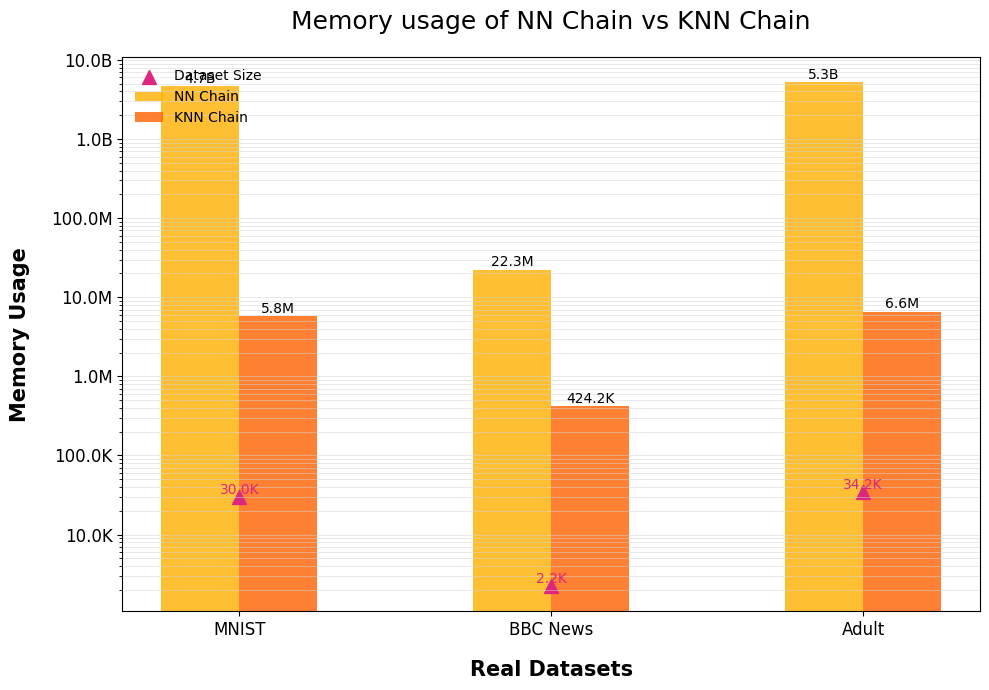

In [50]:
plot_mem(real_nn_mems, real_knn_mems, dataset_sizes_real, 'Real Datasets', ['MNIST', 'BBC News', 'Adult'], (10,8))

In [47]:
new_ks = [1, 3, 15, 25, 35]

In [41]:
mnist_mem = [5755038., 5753516., 5753516., 5753748., 5754340.]

In [42]:
mnist_mem = wrapper_mem(mnist_data[:30000], new_ks, 20)
print(mnist_mem)

[5755038.0, 5753516.0, 5753516.0, 5753748.0, 5754340.0]


In [44]:
bbc_mem = [424236.1, 421231.4, 420822.0, 421064.3, 421617.0]

In [21]:
bbc_mem = wrapper_mem(bbc_matrix, new_ks, 20)
print(bbc_mem)

[424236.1, 421231.4, 420822.0, 421064.3, 421617.0]


In [43]:
adult_mem = [6559781.2, 6559037.6, 6558624.5, 6559455.0, 6560133.8]

In [24]:
adult_mem = wrapper_mem(adult, new_ks, 20)
print(adult_mem)

[6559781.2, 6559037.6, 6558624.5, 6559455.0, 6560133.8]


In [45]:
real_mems = [mnist_mem, bbc_mem, adult_mem]
titles = ['MNIST','BBC News','Adult']

In [46]:
plot_mem(real_mems, new_ks, titles)

NameError: name 'new_ks' is not defined

## Optimal k experiments

In [37]:
# Defining the perfect dataset
init = [0, 1]
n = 7
for i in range(2,n+1):
    last_elem = init[-1]
    new_elem = last_elem+i
    mirror=[x + new_elem for x in init]
    
    init = init + mirror

In [113]:
final = [[x, 0] for x in init]
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [115]:
timings = record_runtimes(final, ks, n = 500)

avg, k = 1 = 0.000336241838
avg, k = 2 = 0.00034539718200000003
avg, k = 3 = 0.0003465008039999998
avg, k = 4 = 0.00036066142199999985
avg, k = 5 = 0.000368905304
avg, k = 6 = 0.00037725686599999987
avg, k = 7 = 0.0003843531960000001
avg, k = 8 = 0.0003915828280000003
avg, k = 9 = 0.00039984054000000006
avg, k = 10 = 0.00041048484600000033


In [116]:
timings = [0.000336241838, 0.00034539718200000003, 0.0003465008039999998, 0.00036066142199999985, 0.000368905304, 0.00037725686599999987, 0.0003843531960000001, 0.0003915828280000003, 0.00039984054000000006,  0.00041048484600000033]
timings = [x*1000 for x in timings] # convert to ms 

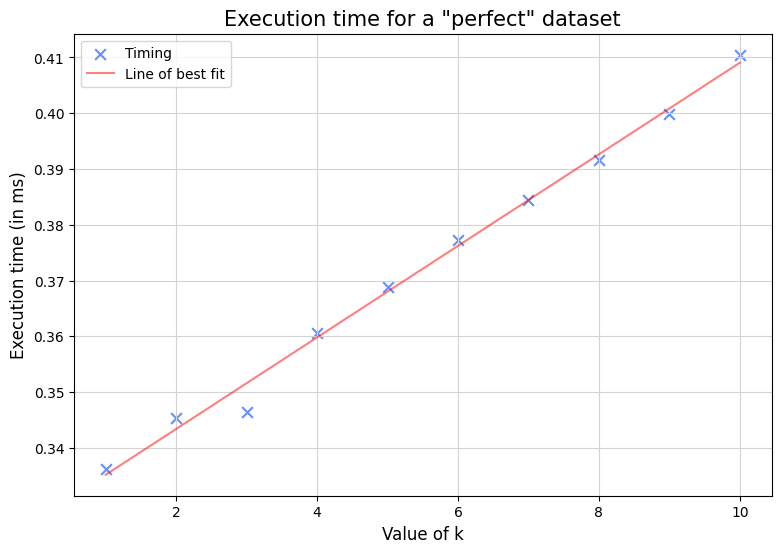

In [120]:
slope, intercept = np.polyfit(ks, timings, 1)
fit_line = np.polyval([slope, intercept],ks)

plt.figure(figsize=(9, 6))

plt.scatter( ks, timings , s = 60, c = "#648FFF" , marker = "x", label = "Timing")
plt.plot(ks, fit_line, linewidth=1.5, color="r", alpha=0.5, label = "Line of best fit")

plt.title('Execution time for a "perfect" dataset', fontsize=15)
plt.xlabel("Value of k", fontsize=12)
plt.ylabel("Execution time (in ms)", fontsize=12)
plt.grid(c="#d3d3d3")
plt.legend()

plt.show()

In [121]:
z = knn_chain(final, 1)

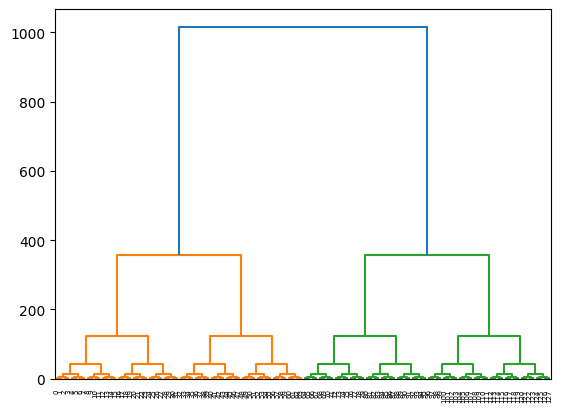

In [122]:
# dendrogram of perfect dataset clustering
dendrogram(z)
plt.show()